# ML Task 2.4 - Evaluating hyperparameters - LSTM

## Table of Contents

#### 01. Import libraries and datasets

#### 02. Data preprocessing

#### 03. More imports, subset Madrid, split train/test, z-score scaling, reshape X datasets

#### 04. Define LSTM model, run Bayesian optimization via Keras Tuner, retrieve & evaluate best model

#### 05. Training history, learning curves, confusion matrix for Madrid weather station

#### 06. Consolidate scripts to run full pipeline on Stockholm weather station

#### 07. Consolidate scripts to run full pipeline on Maastricht weather station

#### 08. Results, interpretation

### 01. Import libraries and datasets

In [1]:
# Partial import: more libraries and functions to be imported later
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
# Create path to dataset location
path = r'C:\Users\dirk8\CareerFoundry\07-2025 Machine Learning With Python\Datasets\Unsupervised'

In [5]:
# Import unscaled weather dataset and Pleasant Weather answers dataset, respectively, without the index column
pleas_ans = pd.read_excel(os.path.join(path, 'answers_pleasant_weather_no_date.xlsx'), index_col=None)
df_unscaled = pd.read_excel(os.path.join(path, 'cleaned_weather_data_task_2.2.xlsx'), index_col=None)

### 02. Data preprocessing

#### Two of the datasets used in the prior part 1 of this Task (for the Random Forests model) are used here.  Preprocessing steps taken were explained in that notebook (Random Forests hyperparameter optimization) script.

In [7]:
# Check dimensions
print(df_unscaled.shape)
print(pleas_ans.shape)

(22950, 135)
(22950, 15)


In [9]:
# Check a few lines of the weather dataset
df_unscaled.head(2)

,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BELGRADE_cloud_cover,...,STOCKHOLM_temp_max,VALENTIA_cloud_cover,VALENTIA_humidity,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max
0,7,0.85,1.018,0.32,0.09,0.7,6.5,0.8,10.9,1,...,4.9,5,0.88,1.0003,0.45,0.34,4.7,8.5,6.0,10.9
1,6,0.84,1.018,0.36,1.05,1.1,6.1,3.3,10.1,6,...,5.0,7,0.91,1.0007,0.25,0.84,0.7,8.9,5.6,12.1


In [11]:
# Check a few lines of the Pleasant weather answers dataset
pleas_ans.head(2)

,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
# Check for missing data in the weather dataset
df_unscaled.isnull().sum().sum()

0

In [15]:
# Check for missing data in the Pleasant weather answers dataset
pleas_ans.isnull().sum().sum()

0

### 03. More imports, subset Madrid, split train/test, z-score scaling, reshape X datasets

#### This Task 2.4 (part 2) will use Bayesian-based hyperparameter optimization for the LSTM model.  This will also follow the Task 2.2 Bonus section logic of fitting the model to individual weather stations (e.g. not 135 station-features, to avoid weather data structure mismatches with the y label dataset, and attendant meaningless results). Madrid, Stockholm and Maastricht are selected for analysis, and comparison with Task 2.2 Bonus section results. In Task 2.2, the LSTM hyperparameters were not optimized at all.

#### The script below will:
##### Add necessary imports.
##### Subset Madrid weather station.
##### Prepare train/test split (75/25), as NumPy arrays.
##### Z-score scale Madrid's 9 features (using StandardScaler, fitted only on training).
##### Reshape X train & test datasets for the LSTM model.
##### Critically, timesteps=1 is applied to restrict the LSTM model to using same-day (not prior period) data to predict each day's label outcome.
##### The timestep selection made is to examine what influence that restriction may have on LSTM model performance predicting y labels.

In [17]:
# Imports for LSTM modeling + optimization
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    classification_report, confusion_matrix, precision_score, recall_score
)
from scikeras.wrappers import KerasClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import warnings
warnings.filterwarnings("ignore")

# Parameters
random_seed = 42
station = "MADRID"
test_size = 0.25
timesteps = 1  # single-day input

# 1. Extract Madrid X and y
X_madrid = df_unscaled[[col for col in df_unscaled.columns if col.startswith(f"{station}_")]].copy()
y_madrid = pleas_ans[f"{station}_pleasant_weather"].copy()

# 2. Train/test split before scaling (scale only training!)
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_madrid, y_madrid, test_size=test_size, random_state=random_seed, stratify=y_madrid
)

# 3. Scale input features (z-score, fit only on train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

# 4. Reshape for LSTM: (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], timesteps, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], timesteps, X_test_scaled.shape[1]))

# Confirm dimensions
print("X_train_lstm shape:", X_train_lstm.shape)
print("X_test_lstm shape:", X_test_lstm.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train_lstm shape: (17212, 1, 9)
X_test_lstm shape: (5738, 1, 9)
y_train shape: (17212,)
y_test shape: (5738,)


### 04. Define LSTM model, run Bayesian optimization via Keras Tuner, retrieve & evaluate best model

#### Comment: scikeras and scikit-optimize are prone to breakage due to versioning conflicts.  Thus, the more stable, actively-maintained Keras Tuner's BayesianOptimization tuner is chosen here. It works natively with Keras/TensorFlow.

#### The script below (for Madrid weather station) will:

##### Run Bayesian optimization via Keras Tuner.

##### Define an LSTM model using build_model() with tunable hyperparameters.

##### Initialize BayesianOptimization tuner.

##### Run tuner search over 10 trials.

##### Retrieve best model and evaluate it on test data.

##### Output accuracy, F1, precision, recall metrics, and a classification report.

In [26]:
# ------------------------------------------------------
# 1. Additional Imports
# ------------------------------------------------------
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score

# ------------------------------------------------------
# 2. Define the LSTM Model Builder for Keras Tuner
# ------------------------------------------------------
def build_model(hp):
    model = Sequential()
    model.add(
        LSTM(
            units=hp.Int("lstm_units", min_value=16, max_value=128, step=16),
            input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]),
            return_sequences=False,
        )
    )
    model.add(
        Dropout(hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1))
    )
    model.add(
        Dense(
            units=hp.Int("dense_units", min_value=8, max_value=64, step=8),
            activation="relu",
        )
    )
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

# ------------------------------------------------------
# 3. Setup Bayesian Optimization Search with Keras Tuner
# ------------------------------------------------------
tuner = kt.BayesianOptimization(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    directory="tuner_dir",
    project_name="lstm_madrid_bayesian"
)

# Show summary of search space
tuner.search_space_summary()

# ------------------------------------------------------
# 4. Perform Hyperparameter Search
# ------------------------------------------------------
tuner.search(
    X_train_lstm, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)

# ------------------------------------------------------
# 5. Retrieve Best Model and Evaluate
# ------------------------------------------------------
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate on test set
y_pred_prob = best_model.predict(X_test_lstm).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)

print(f"\n Evaluation on Test Set:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {rec:.4f}")
print(f"Precision: {prec:.4f}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

Trial 10 Complete [00h 00m 15s]
val_accuracy: 0.988091766834259

Best val_accuracy So Far: 0.9907057881355286
Total elapsed time: 00h 02m 15s
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

 Evaluation on Test Set:
Accuracy: 0.9881
F1 Score: 0.9868
Recall: 0.9914
Precision: 0.9822

 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3176
           1       0.98      0.99      0.99      2562

    accuracy                           0.99      5738
   macro avg       0.99      0.99      0.99      5738
weighted avg       0.99      0.99      0.99      5738



### 05. Training history, learning curves, confusion matrix for Madrid weather station

#### The script below will:
##### Show training history run for the determined best combination of hyperparameters model run.
##### Plot learning curves for the weather station.
##### Output a confusion matrix for the weather station.

Epoch 1/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9327 - loss: 0.1873 - val_accuracy: 0.9585 - val_loss: 0.1118
Epoch 2/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9636 - loss: 0.0943 - val_accuracy: 0.9732 - val_loss: 0.0763
Epoch 3/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9728 - loss: 0.0734 - val_accuracy: 0.9761 - val_loss: 0.0710
Epoch 4/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9775 - loss: 0.0624 - val_accuracy: 0.9794 - val_loss: 0.0541
Epoch 5/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9807 - loss: 0.0540 - val_accuracy: 0.9824 - val_loss: 0.0455
Epoch 6/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9840 - loss: 0.0464 - val_accuracy: 0.9847 - val_loss: 0.0389
Epoch 7/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9846 - loss: 0.0416 - val_accuracy: 0.9864 - val_loss: 0.0390
Epoch 8/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9850 - loss: 0.0403 - val_accuracy: 0.

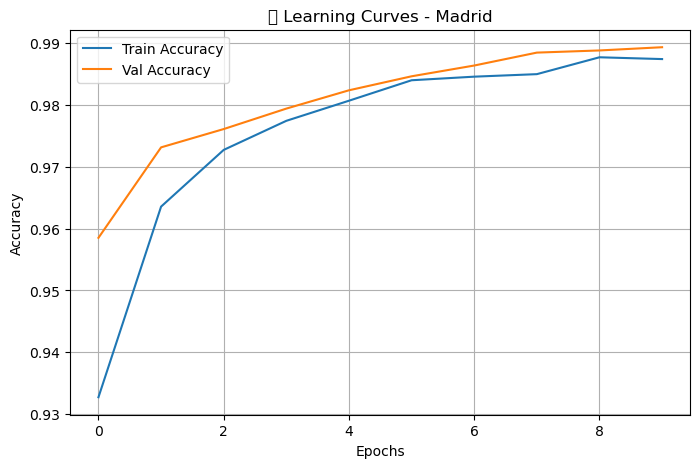

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


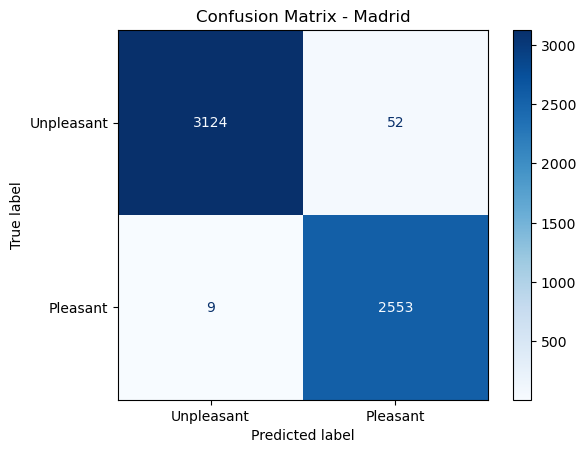

In [29]:
# --------------------------------------------------------------------------------
# Block A: Plot Learning Curves + Confusion Matrix (Madrid Only)
# --------------------------------------------------------------------------------

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# 1. Rebuild the best model to retrieve training history (if needed)
def build_best_lstm_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1, 9)),
        tf.keras.layers.LSTM(units=96, return_sequences=False),
        tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    return model

# Train it again to get training history for plotting
model = build_best_lstm_model()
history = model.fit(
    X_train_lstm, y_train,
    validation_data=(X_test_lstm, y_test),
    epochs=10,
    batch_size=32,
    verbose=1
)

# 2. Plot Learning Curves
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('📈 Learning Curves - Madrid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 3. Confusion Matrix
y_pred_probs = model.predict(X_test_lstm)
y_pred_labels = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Unpleasant', 'Pleasant'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Madrid')
plt.show()

### 06. Consolidate scripts to run full pipeline on Stockholm weather station

### Stockholm weather station

Trial 10 Complete [00h 00m 24s]
val_accuracy: 0.9921579957008362

Best val_accuracy So Far: 0.9947720170021057
Total elapsed time: 00h 03m 37s
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 Evaluation on Test Set:
Accuracy: 0.9934
F1 Score: 0.9806
Recall: 0.9846
Precision: 0.9766

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4764
           1       0.98      0.98      0.98       974

    accuracy                           0.99      5738
   macro avg       0.99      0.99      0.99      5738
weighted avg       0.99      0.99      0.99      5738



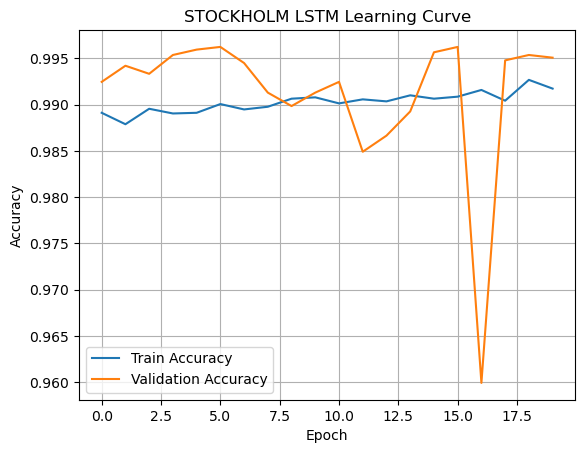

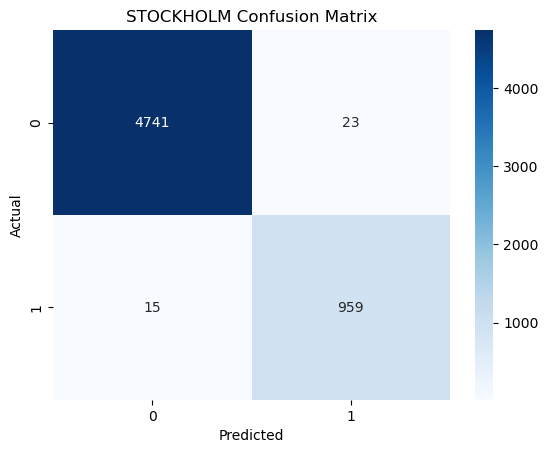

In [32]:
# ------------------------------------------------------
# 1. Imports and Seed
# ------------------------------------------------------
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
import seaborn as sns

tf.random.set_seed(123)
np.random.seed(123)

# ------------------------------------------------------
# 2. Extract and Prepare STOCKHOLM Data
# ------------------------------------------------------
station = 'STOCKHOLM'
X = df_unscaled[[col for col in df_unscaled.columns if col.startswith(station)]].copy()
y = pleas_ans[f"{station}_pleasant_weather"].copy()

# Split and reshape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)

# Standardize (train-only fit)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM (timesteps = 1)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# ------------------------------------------------------
# 3. Define Model Builder for Tuner
# ------------------------------------------------------
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), input_shape=(1, X_train_lstm.shape[2])))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# ------------------------------------------------------
# 4. Random Search with Keras Tuner
# ------------------------------------------------------
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name=f'{station}_lstm_tuning'
)

tuner.search_space_summary()

tuner.search(X_train_lstm, y_train, epochs=20, validation_split=0.2, verbose=2)

# ------------------------------------------------------
# 5. Retrieve Best Model and Evaluate
# ------------------------------------------------------
best_model = tuner.get_best_models(num_models=1)[0]

# Save training history for learning curves
history = best_model.fit(X_train_lstm, y_train, epochs=20, validation_split=0.2, verbose=0)

# Predict and evaluate
y_pred_prob = best_model.predict(X_test_lstm).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)

print(f"\n Evaluation on Test Set:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {rec:.4f}")
print(f"Precision: {prec:.4f}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# ------------------------------------------------------
# 6. Plot Learning Curves
# ------------------------------------------------------
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'{station} LSTM Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------
# 7. Confusion Matrix
# ------------------------------------------------------
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'{station} Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### 07. Consolidate scripts to run full pipeline on Maastricht weather station

### Maastricht weather station

Trial 10 Complete [00h 00m 17s]
val_accuracy: 0.6151611804962158

Best val_accuracy So Far: 0.9770548939704895
Total elapsed time: 00h 02m 51s
Epoch 1/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9778 - loss: 0.0590 - val_accuracy: 0.9776 - val_loss: 0.0604
Epoch 2/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9787 - loss: 0.0571 - val_accuracy: 0.9782 - val_loss: 0.0592
Epoch 3/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9808 - loss: 0.0553 - val_accuracy: 0.9800 - val_loss: 0.0568
Epoch 4/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9802 - loss: 0.0533 - val_accuracy: 0.9811 - val_loss: 0.0550
Epoch 5/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9804 - loss: 0.0518 - val_accuracy: 0.9808 - val_loss: 0.0540
Epoch 6/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9809 - loss: 0.0506 - val_accuracy: 0.9817 - val_loss: 0.0520
Epoch 7/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9821 - loss: 0.0499 - v

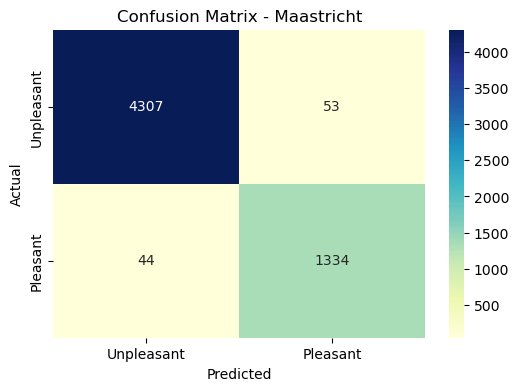

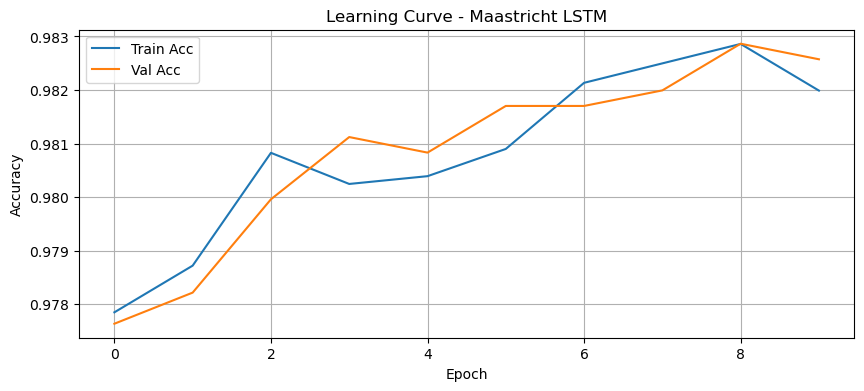

In [35]:
# ----------------------------------------
# 1. Import & Select Maastricht Data
# ----------------------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extract Maastricht features and label
maastricht_cols = [col for col in df_unscaled.columns if col.startswith("MAASTRICHT")]
X = df_unscaled[maastricht_cols].copy()
y = pleas_ans["MAASTRICHT_pleasant_weather"].copy()

# Train/test split
split_idx = int(len(X) * 0.75)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Scale (fit only on training set!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM: (samples, timesteps=1, features=9)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# ----------------------------------------
# 2. Define Model Builder for Keras Tuner
# ----------------------------------------
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('lstm_units', min_value=16, max_value=64, step=16), input_shape=(1, X_train.shape[1])))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'adadelta']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# ----------------------------------------
# 3. Hyperparameter Tuning
# ----------------------------------------
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='maastricht_tuning',
    project_name='lstm_maastricht'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(
    X_train_lstm, y_train,
    epochs=15,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=1
)

# ----------------------------------------
# 4. Best Model, Final Training, and Evaluation
# ----------------------------------------
best_model = tuner.get_best_models(num_models=1)[0]
history = best_model.fit(X_train_lstm, y_train, epochs=10, validation_split=0.2, verbose=1)

# Predict
y_pred_prob = best_model.predict(X_test_lstm).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)

print(f"\n Evaluation on Test Set:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {rec:.4f}")
print(f"Precision: {prec:.4f}")
print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# ----------------------------------------
# 5. Confusion Matrix
# ----------------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Unpleasant', 'Pleasant'], yticklabels=['Unpleasant', 'Pleasant'])
plt.title('Confusion Matrix - Maastricht')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ----------------------------------------
# 6. Learning Curves
# ----------------------------------------
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Learning Curve - Maastricht LSTM')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### 08. Results, interpretation

#### Results comparison: Tasks 2.2 vs 2.4

#### The LSTM model, with Bayesian hyperparameter tuning, was applied individually to three weather stations: Madrid, Stockholm and Maastricht, to compare with some of the non-optimized (hyperparameter) results in a prior Task 2.2 Bonus segment for LSTM. As before, z-score scaled weather data for 1960-2022 (Oct 31) was used.

#### Madrid: accuracy, f1, recall, precision metrics increased from their 84-91% range to 98-99%, using Bayesian hyperparameter tuning and a timestep=1 on the X train/test dataset reshaping.  Confusion matrix improved considerably post-optimization.
#### Stockholm: the metrics increased from their 51-85% range to 97-99%, with very large improvement to the confusion matrix.
#### Maastricht: the metrics increased from their 62-83% range to 96-98%, with material improvement to the confusion matrix.

#### Train/test learning curves at all 3 weather stations improved considerably post-optimization (comparing the curves in this Task 2.4 with those in the Bonus segment of Task 2.2 part 1).  Their shape and small ending gap size suggest that any overfitting of the LSTM model to training data was trivial, at most.  Not a concern.

#### Interpretation

#### Bayesian hyperparameter optimization led to significantly improved LSTM model results, versus the non-optimized model builds and runs in the Task 2.2 Bonus segment.

#### The selection of timestep=1 (in this Task 2.4) restricted the LSTM model to using only same-day weather data to predict a weather station's y label outcome (Pleasant or Unpleasant weather) for that day.  The significantly-improved LSTM model classification prediction results in Task 2.4 may support my sub-thesis that the deterministic rules & thresholds approach to creating the y labels (my primary thesis) used same-day weather data to decide a given day's label outcome.  Timestep value selection can have a large impact on a temporally-minded model like LSTM.